In [9]:
# Install necessary libraries
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow mlflow

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mlflow

# Configure plotting
%matplotlib inline
sns.set_style("whitegrid")

print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open Volume
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F
Date                                                                 
2021-02-11  1824.900024  1845.000000  1820.900024  1840.500000    602
2021-02-12  1821.599976  1827.500000  1809.199951  1825.000000    259
2021-02-16  1797.199951  1823.400024  1787.300049  1820.900024   1141
2021-02-17  1771.099976  1789.699951  1768.800049  1785.800049    614
2021-02-18  1773.400024  1784.599976  1766.000000  1776.099976    587


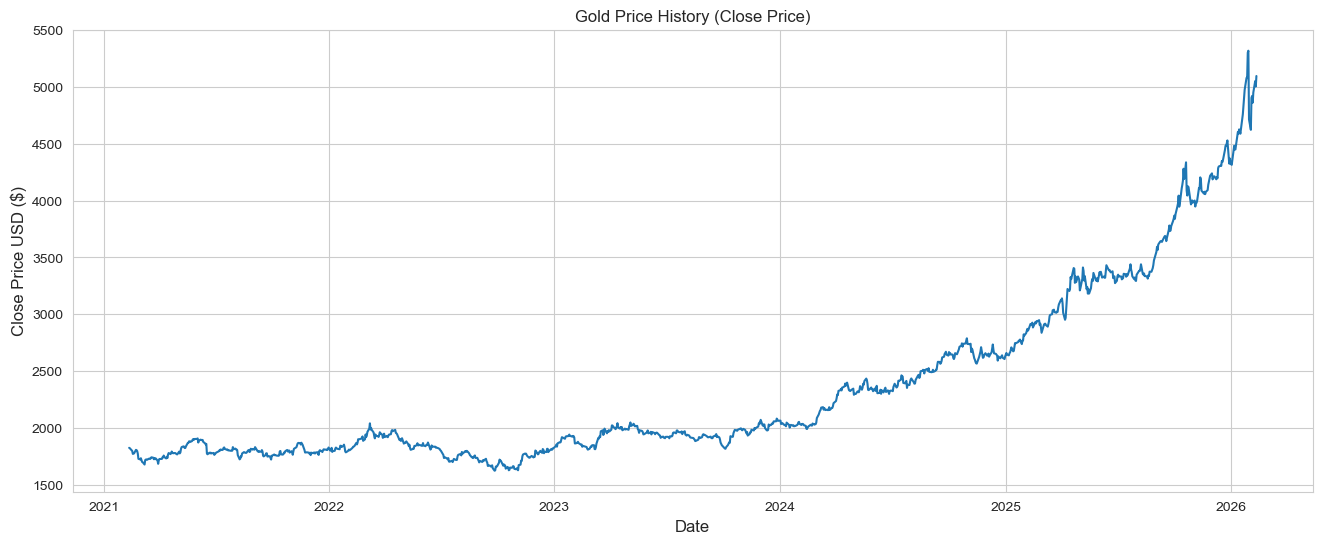

Data fetched and plotted.


In [10]:
# Download Gold data (5 years of history)
# 'GC=F' is the ticker symbol for Gold Futures
df = yf.download('GC=F', period='5y', interval='1d')

# Display the first few rows to verify data
print(df.head())

# Plot the Closing Price
plt.figure(figsize=(16,6))
plt.title('Gold Price History (Close Price)')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.show()

print("Data fetched and plotted.")

In [11]:
# 1. Handle potential Multi-Index from yfinance
if isinstance(df.columns, pd.MultiIndex):
    # Select just the 'Close' column safely
    data = df.xs('Close', axis=1, level=0)
else:
    data = df['Close']

# 2. Convert to Numpy and Reshape
# This .reshape(-1, 1) fixes the ValueError
dataset = data.values.reshape(-1, 1)

# Ensure it is numeric
dataset = dataset.astype('float32')

# 3. Clean NaNs/Empty values
dataset = dataset[~np.isnan(dataset).any(axis=1)]

# 4. Calculate split
training_data_len = int(np.ceil(len(dataset) * 0.8))
print(f"Dataset Shape: {dataset.shape}")
print(f"Training Data Length: {training_data_len}")

# 5. Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print("Data scaled successfully.")

Dataset Shape: (1258, 1)
Training Data Length: 1007
Data scaled successfully.


In [12]:
# Create the training data
train_data = scaled_data[0:training_data_len, :]

# Split into x_train and y_train
x_train = []
y_train = []
SEQ_LEN = 60  # Look back 60 days

for i in range(SEQ_LEN, len(train_data)):
    x_train.append(train_data[i-SEQ_LEN:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM [samples, time steps, features]
# This 3D shape is required by TensorFlow
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f" Training Data Shape: {x_train.shape}")

 Training Data Shape: (947, 60, 1)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Build a Deeper Model
model = Sequential()
# Layer 1: More neurons (100) and Return Sequences=True
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) # Prevents overfitting

# Layer 2: Another LSTM layer
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Output
model.add(Dense(25))
model.add(Dense(1))

# 2. Compile with a lower learning rate (smoother learning)
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Train for MORE Epochs (100 instead of 50)
model.fit(x_train, y_train, batch_size=32, epochs=100)

# 4. Save as Version 3
model.save('gold_price_prediction_model_2.keras') 
# (Keep the name same to overwrite the old one easily)

Epoch 1/100


C:\Users\sunil\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0019
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.7804e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.3955e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.9101e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0548e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5669e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.6726e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.7797e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.4934e-04
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.4470e-04
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.3920e-04
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5217e-04
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.8075e-04
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.4336e-04
Epoch 15/100
30/3

In [14]:
# 1. Create the testing data
test_data = scaled_data[training_data_len - SEQ_LEN: , :]

# 2. Create x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :] # Actual prices (not scaled)

for i in range(SEQ_LEN, len(test_data)):
    x_test.append(test_data[i-SEQ_LEN:i, 0])

# 3. Convert to numpy and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# 4. Get predictions
predictions = model.predict(x_test)
# Inverse transform to get actual prices back (un-scale)
predictions = scaler.inverse_transform(predictions)

# 5. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error: {rmse}")

print("Predictions made and error calculated.")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
Root Mean Squared Error: 78.64238739013672
Predictions made and error calculated.


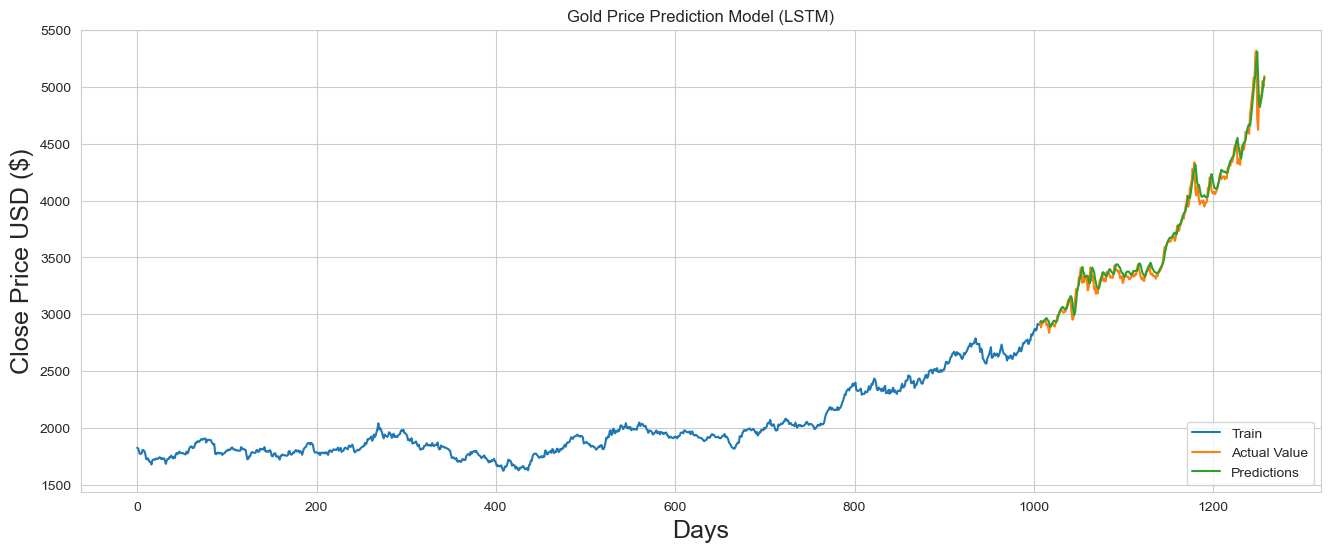

Graph generated successfully.


In [15]:
# Fallback: Plot using the raw numpy arrays directly to avoid KeyError

plt.figure(figsize=(16,6))
plt.title('Gold Price Prediction Model (LSTM)')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# 1. Plot the Training Data (Blue)
# We slice the dataset from start to the split point
plt.plot(dataset[:training_data_len])

# 2. Plot the Actual Values for the Test period (Red)
# We create a range of numbers for the x-axis so it shifts to the right side of the graph
valid_range = range(training_data_len, len(dataset))
plt.plot(valid_range, dataset[training_data_len:])

# 3. Plot the Predictions (Yellow/Orange)
# These align with the valid_range
plt.plot(valid_range, predictions)

plt.legend(['Train', 'Actual Value', 'Predictions'], loc='lower right')
plt.show()

print("Graph generated successfully.")

In [16]:
import joblib

# Define the filenames
model_filename = 'gold_price_prediction_model_2.keras'
scaler_filename = 'gold_price_prediction_scaler_2.gz'

# 1. Save the Model
model.save(model_filename)
print(f"Model saved as '{model_filename}'")

# 2. Save the Scaler
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved as '{scaler_filename}'")

Model saved as 'gold_price_prediction_model_2.keras'
Scaler saved as 'gold_price_prediction_scaler_2.gz'


In [19]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import pandas as pd 

# 1. Load the saved model and scaler
# Ensure these match the filenames you used in Step 9
loaded_model = load_model('gold_price_prediction_model_2.keras')
loaded_scaler = joblib.load('gold_price_prediction_scaler_2.gz')

def predict_with_date(data, full_dataframe):
    # A. PREPARE DATA
    # Get the last 60 days of prices
    last_60_days = data[-60:]
    
    # Scale the data using the loaded scaler
    # We must reshape it to (-1, 1) because the scaler expects a 2D array
    last_60_days_scaled = loaded_scaler.transform(last_60_days.reshape(-1, 1))
    
    # Reshape for LSTM (1 sample, 60 time steps, 1 feature)
    X_input = np.reshape(last_60_days_scaled, (1, 60, 1))
    
    # B. PREDICT PRICE
    predicted_price_scaled = loaded_model.predict(X_input)
    predicted_price = loaded_scaler.inverse_transform(predicted_price_scaled)
    final_price = float(predicted_price[0][0])
    
    # C. CALCULATE DATE
    # Get the last date from your original dataframe
    last_date = full_dataframe.index[-1]
    
    # Add 1 day to get "Tomorrow"
    # Note: In real trading, you might need to skip weekends, but for this project +1 day is fine
    next_date = last_date + pd.Timedelta(days=1)
    
    return next_date, final_price

# --- RUN PREDICTION ---

# We use 'dataset' (the numpy array of prices) and 'df' (the original table with dates)
prediction_date, future_price = predict_with_date(dataset, df)

print(f"\n==============================================")
print(f"Prediction Date: {prediction_date.strftime('%Y-%m-%d')}")
print(f"Predicted Price: ${future_price:.2f}")
print(f"==============================================")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

Prediction Date: 2026-02-12
Predicted Price: $5124.23


In [18]:
import os
print(os.getcwd())

C:\Users\sunil\Documents\gold_price_project
